# 분류 성능 평가
## 1. 분류 결과표
- `Confusion_matrix`
- `calssification_report`

## 2. 이진 분류 결과표

<table>
<thead>
    <tr>
        <th></th>
        <th>Positive라고 예측</th>
        <th>Negative라고 예측</th>
    </tr>
</thead>

<tbody>
    <tr>
        <td>실제 Positive</td>
        <td>True Positive</td>
        <td>False Negative</td>
    </tr>

<tr>
    <td>실제 Negative</td>
    <td>False Positive</td>
    <td>True Negative</td>
</tr>
</tbody>
</table>

- recall(TP/TP+FN) & fall-out(FP/FP+TN)은 양의 상관관계
    - 양성 판단기준 threshold 낮춤
    - -> 양성 판단 표본(TP) 증가: recall 증가
    - -> 양성 예측 범위 표본 (FP) 증가: fall-out 증가
- precision & recall은 대개 음의 상관 관계


### 2.1 Accuracy 
$$
accuracy = \dfrac{TP + TN}{TP+TN+FP+FN}
$$
### 2.2 Precision
- 정밀도, 유죄율
- 유죄로 예측했을 때, 실제 유죄
$$
precision = \dfrac{TP}{TP+FP}
$$


### 2.3 Recall
- 재현율, 검거율
- 실제 유죄 건수 중, 검거한 건수의 비율
$$
recall = \dfrac{TP}{TP+FN}
$$

### 2.4 Fall-out
- 위양성율, 원죄율
- 억울한 사람 비율
$$
Fall-out = \dfrac{FP}{FP+TN}
$$

### 2.5 F(beta) score
- precision과 recall 가중 조화 평균

$$
F_\beta = (1+\beta^2)\,\,(\text{precision} \, \times \, \text{recall}) \, / \, (\beta^2 \text{precision} + \text{recall})
$$
- F1 scroe
    - beta = 1
$$
F_1 = 2 \cdot precision \cdot recall / \,\,(precision + recall)
$$

## 3. ROC (Receiver Operator Charateristic) 커브
- 클래스 판별 기준값 변화에 따른 fall-out & recall 변화 시각화
- 즉, ROC 커브는 클래스 판별 기준값이 달라졌을 때, 판결 결과 어떻게 달라지는지
- 판별함수: 판별 평면으로부터의 거리.(모든 이진 분류 모형은 판별함수 가짐)
- 기준값threshold = 0
    - 판별함수 값 음수: 0
    - 판별함수 값 양수: 1
- code
    - `decision_function`: 판별 함수값 계산
    - `roc_curve`

## 4. AUC (Area Under the Curve)
- ROC curve의 면적
- Fall-out 대비 recall 값 클수록 AUC 1에 가깝고, 민감한 모형

실습

In [1]:
# 로지스틱스
from sklearn.datasets import load_iris
iris = load_iris()
df_f = pd.DataFrame(iris.data, columns=iris.feature_names)
df_t = pd.DataFrame(iris.target, columns=["target"])
df = pd.concat((df_f.iloc[:, 0], df_t), axis=1)
cond = df.target < 2
df = df[cond]
df.tail()

,sepal length (cm),target
95,5.7,1
96,5.7,1
97,6.2,1
98,5.1,1
99,5.7,1


In [2]:
from scipy import stats
import statsmodels.api as sm

stats.chisquare = lambda chisq, df: stats.chi2.sf(chisq, df)

X = sm.add_constant(df.iloc[:, 0])
y = df.iloc[:, 1]

logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.321056
         Iterations 8


In [9]:
predicted = logit_res.predict(X)
y_pred = (predicted > 0.5).astype(int)
y_true = y

## confusion_matrix

In [11]:
# 0 -> 0: 45, 1 -> 1: 44
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[45  5]
 [ 6 44]]


## classification_report

In [12]:
#f1-score avg 기준으로 
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['setosa', 'versicolor']))

              precision    recall  f1-score   support

      setosa       0.88      0.90      0.89        50
  versicolor       0.90      0.88      0.89        50

   micro avg       0.89      0.89      0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



## ROC curve

In [48]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X, y)

y_hat = model.predict(X)
f_value = model.decision_function(X)

df_sk = pd.DataFrame(np.vstack([f_value, y_hat, np.array(y)]).T, columns=["f", "y_hat", "y"])
df_sk = df_sk.sort_values("f", ascending=False).reset_index(drop=True)
df_sk.tail()

,f,y_hat,y
95,-0.785816,0.0,0.0
96,-0.878460,0.0,0.0
97,-0.878460,0.0,0.0
98,-0.878460,0.0,0.0
99,-0.971103,0.0,0.0


In [49]:
# threshold=0 을 기준으로 이진분류 결과표, 재현율, 위양성율 계산
confusion_matrix(y, y_hat)

array([[40, 10],
       [ 5, 45]])

In [50]:
recall = 40 / (40 + 10)
fallout = 5 / (5 + 45)
print("recall = ", recall)
print("fallout = ", fallout)

recall =  0.8
fallout =  0.1


자동화 roc_curve

In [52]:
# 변화되는 기준값, 기준값 사용시의 재현율과 위양성률
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, model.decision_function(X))
fpr, tpr, thresholds

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.02, 0.06, 0.06, 0.1 , 0.2 , 0.22, 0.28, 0.44, 0.6 , 0.68, 0.78,
        0.82, 0.9 , 0.92, 0.98, 1.  ]),
 array([0.  , 0.02, 0.06, 0.12, 0.16, 0.18, 0.22, 0.28, 0.32, 0.48, 0.52,
        0.58, 0.68, 0.78, 0.88, 0.9 , 0.9 , 0.92, 0.94, 0.98, 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  ]),
 array([ 2.5302653 ,  1.5302653 ,  1.34497877,  1.2523355 ,  1.15969224,
         1.06704897,  0.97440571,  0.88176244,  0.78911917,  0.60383264,
         0.51118938,  0.41854611,  0.32590284,  0.23325958,  0.14061631,
         0.04797305, -0.04467022, -0.13731348, -0.22995675, -0.32260002,
        -0.41524328, -0.50788655, -0.60052981, -0.69317308, -0.78581635,
        -0.87845961, -0.97110288]))

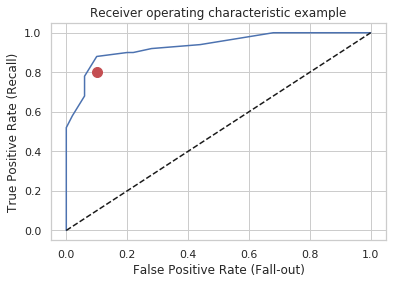

In [59]:
# 정확도 최대화하는 모형
# plot by decision_function
%matplotlib inline
plt.plot(fpr, tpr, label="Logitic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel("False Positive Rate (Fall-out)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver operating characteristic example")
plt.show()

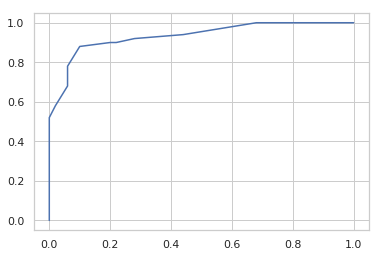

In [94]:
# plot by predict_proba
fpr1, tpr1, thr1 = roc_curve(y, model.predict_proba(np.array(X))[:, 1])
plt.plot(fpr1, tpr1)
plt.show()

## AUC (Area Under the Curve)

In [60]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.9326